# Inspect direct beam histogram with QuantiCam
- [X] Redirect laser elongated profile directly into the sensor to observe sharp peak without internal reflection from the obscure box
- [X] HDF5 data acquisition stream
- [ ] Peak detection algorithm employed
- [ ] Model Poission noise for the direct path

| Layout | Illumination |
|:--------:|:--------|
| ![alt text](./img/PXL_20250317_Direct_Laser_Hist_Layout.jpg "Beam path") | ![alt text](./img/PXL_20250317_Direct_Laser_Hist_DarkIllumination.jpg "Beam path") |  

## Setup connection to the QC FPGA
- Write FW
- Config voltages
- Config sensor settings for the mode we use

In [12]:
using QuantiCam

fw_path = "../hw/TOP_7310_modes_1_2.bit"
#fw_path = "../hw/photon_cnt_tcspc_xem7310-a200_v1.6.4.5.bit"

if !(@isdefined qc) || qc === nothing || qc.fpga.bitfile != fw_path
    if (@isdefined qc) && qc!== nothing
        cleanup!(qc)
    end
    qc = QCBoard(fw_path, "../config/tcspc.json")
    init_board!(qc)
else
    # Try to reconfigure or cleanup and initialise from the begining
    try
        reload_config(qc, "../config/tcspc.json")
        config_sensor(qc)
    catch
        cleanup!(qc)
    end
end

[ Info: Precompiling QuantiCam [42916ebc-e1b0-4bae-bca4-6df6ee911bda] (cache misses: include_dependency fsize change (2), wrong dep version loaded (6))
[ Info: Spawning HDF5 collector thread
[ Info: Returning channel to caller
[ Info: Creating dataset for frames of type: Int64 and size: (2, 10, 20) in group: HDF5.Group: /test_group (file: /tmp/test.h5)


Test Summary:       | Pass  Total  Time
Test HDF5 Collector |    6      6  4.0s
Test Summary:                              | Pass  Total  Time
Check the FrontPanel API works as expected |    2      2  0.0s
Test Summary:          | Pass  Total  Time
Test FPGA construction |    1      1  0.0s


[ Info: Cleaning up FPGA connection to OK FrontPanel
┌ Warning: FPGA was not open. Program might have exited unexpectedly!
└ @ OpalKelly ~/.julia/packages/OpalKelly/7XnP8/src/types.jl:35
[ Info: FPGA desctructed! => Safe exit
[ Info: Opal Kelly to API Comms setup in progress...


Scanning USB for Opal Kelly devices...
Found 1 Opal Kelly device(s)
Serial number of device 0 is 1908000OVV


[ Info: Device opened with id=Opal Kelly XEM7310 and board model=ok_brdXEM7310A200
[ Info: Located bit file ../hw/TOP_7310_modes_1_2.bit
[ Info: Firmware written successfuly
[ Info: Firmware revision: 0.0.0
[ Info: Waiting on voltages to stabilize
[ Info: Connected to Sensor
[ Info: Initialize logic parameters necessary to interact with the sensor
[ Info: Reset sensor and set parameters for the MODE of use
[ Info: Sensor configured


In [38]:
cleanup!(qc)
qc = nothing

LoadError: MethodError: no method matching cleanup!(::Nothing)
The function `cleanup!` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  cleanup!([91m::QCBoard[39m)
[0m[90m   @[39m [36mQuantiCam[39m [90m~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/[39m[90m[4mtypes.jl:210[24m[39m


In [63]:
frames = capture_frames(qc, 5000);

┌ Warning: FRAME(280): Frames skipped expected_idx=24 to new_idx=29 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75
┌ Warning: FRAME(500): Frames skipped expected_idx=249 to new_idx=254 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75
┌ Warning: FRAME(682): Frames skipped expected_idx=180 to new_idx=246 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75
┌ Warning: FRAME(863): Frames skipped expected_idx=171 to new_idx=84 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75
┌ Warning: FRAME(1085): Frames skipped expected_idx=50 to new_idx=57 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75
┌ Warning: FRAME(1289): Frames skipped expected_idx=5 to new_idx=9 => Non continuous frames capture
└ @ 

## Test if empty read results in a FIFO_EMPTY error

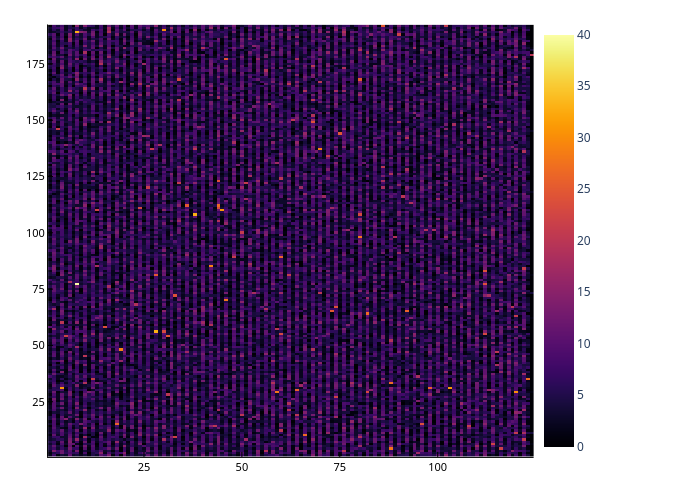

In [67]:
using Plots
#plotlyjs() # plotlyjs would work in a python env with webio_jupyter_extension package
#one_frame = capture_frame(qc)
one_frame = frames[13]
filtered_frame = QuantiCam.filter_code(one_frame)
heatmap(one_frame[:,5:128])

## TCSPC Histogram
- [ ] Aquire N tcspc frames
- [ ] Make histogram for each pixel

# Interpret

- Read frames from HDF5

In [189]:
using QuantiCam

filtered_frames = map(frame -> QuantiCam.filter_code(frame), frames)
typeof(filtered_frames)

Vector{Matrix{Union{Missing, Float32}}} (alias for Array{Array{Union{Missing, Float32}, 2}, 1})

In [355]:
using Statistics

function collect_frames(v::Vector{Matrix{T}}) where T
    n_rows = size(v[1], 1)
    n_cols = size(v[1], 2)
    n_matrices = length(v)
    
    result = Matrix{Vector{T}}(undef, n_rows, n_cols)
    
    for i in 1:n_rows, j in 1:n_cols
        result[i, j] = [v[k][i, j] for k in 1:n_matrices]
    end
    
    return result
end

#tcspc_stream = collect_frames([frames[:,:,i] for i in 1:size(frames,3)])
tcspc_stream_missing = collect_frames(filtered_frames)
tcspc_stream = map(pixel -> collect(skipmissing(pixel)), tcspc_stream_missing)
tcspc_mean = map(pixel -> mean(pixel), tcspc_stream)
tcspc_var = map(pixel -> var(pixel), tcspc_stream);

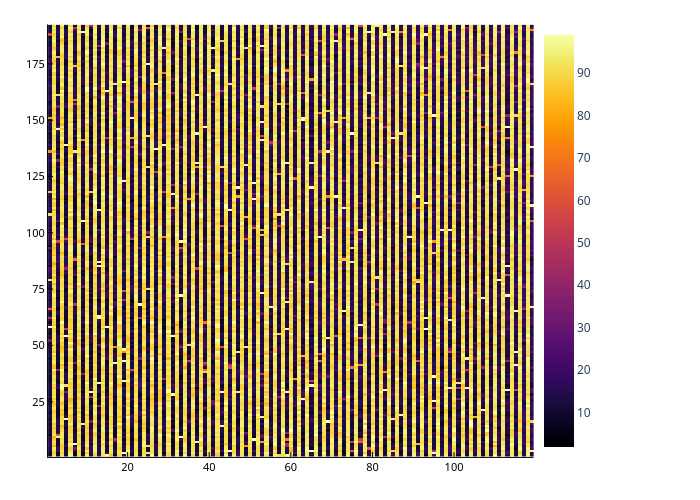

In [25]:
using Plots
plotlyjs()
frames_center = map(frame -> frame[1:192, 1:123], filtered_frames)
tcspc_events = map(pixel -> length(collect((skipmissing(pixel)))), tcspc_stream)
#heatmap(map(pixel -> length(collect((skipmissing(pixel)))), tcspc_stream))
#heatmap(map(pixel -> sum(collect((skipmissing(pixel)))), collect_frames(frames_center)))
heatmap(tcspc_events[:,5:123])
#heatmap(filtered_frames[24])

In [148]:
pixel = UInt16.(tcspc_stream[79, 95])
# For each value in the pixel vector, invert the bits
inverted_pixel = map(value -> bitstring(value)[12:-1:1], pixel)
inverted_pixel_uint16 = map(bits -> parse(UInt16, bits, base=2), inverted_pixel)
println(inverted_pixel_uint16)
println(pixel)
println(inverted_pixel)

UInt16[0x0ce0, 0x0760, 0x0760, 0x0760, 0x0560, 0x0760, 0x0ee0, 0x04e0, 0x08e0, 0x06e0, 0x0260, 0x07e0, 0x0360, 0x0f60, 0x0160, 0x0760, 0x0360, 0x05e0, 0x0ae0, 0x0ee0, 0x0de0, 0x0d60, 0x0de0, 0x0660, 0x0560, 0x0ce0, 0x02e0, 0x0c10, 0x0360, 0x0b60, 0x01e0, 0x04e0, 0x0ce0, 0x00e0, 0x0660, 0x0660, 0x0f60, 0x0760, 0x02e0, 0x0f60, 0x06e0, 0x0f60, 0x06e0, 0x0ee0, 0x04e0, 0x0b60, 0x0ae0, 0x0b60, 0x0b60, 0x0360, 0x04e0, 0x05e0, 0x06e0, 0x0e60, 0x0ce0, 0x03e0, 0x0960, 0x0760, 0x08e0, 0x04e0, 0x0160, 0x00e0, 0x09e0, 0x04e0, 0x0360, 0x0be0, 0x0360, 0x02e0, 0x05e0, 0x0ce0, 0x0360, 0x0ce0, 0x0260, 0x0b60, 0x0de0, 0x0360, 0x06e0, 0x0ae0, 0x08e0, 0x04e0, 0x0560, 0x0010, 0x0a60, 0x0760, 0x0a60, 0x0a60, 0x02e0, 0x0ae0, 0x0360, 0x0c60, 0x0760, 0x0660, 0x0010, 0x0e60, 0x0760, 0x0810, 0x0560, 0x0360, 0x0660, 0x05e0, 0x0ce0, 0x0fe0, 0x0b60, 0x00e0, 0x00e0, 0x0360, 0x02e0, 0x0f60, 0x0760, 0x0760, 0x0d60, 0x04e0, 0x0ce0, 0x04e0, 0x0ce0, 0x0760, 0x0ce0, 0x08e0, 0x01e0, 0x0660, 0x0260, 0x0360, 0x0e60, 0x06e0, 0

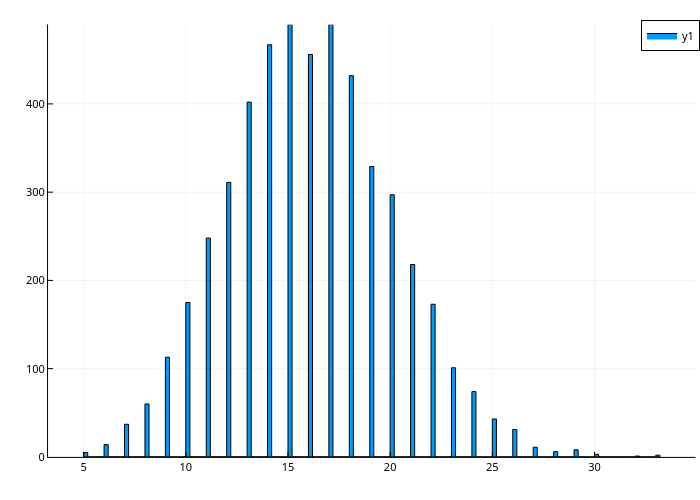

In [139]:
histogram(tcspc_stream[90, 72], bins=200)
#histogram(inverted_pixel_uint16, bins=200, xlabel="Inverted TCSPC Value", ylabel="Count", title="Histogram of Inverted TCSPC Values at Pixel (79, 95)")
#map(x -> UInt16(x) & 0xF, tcspc_stream[75, 45])

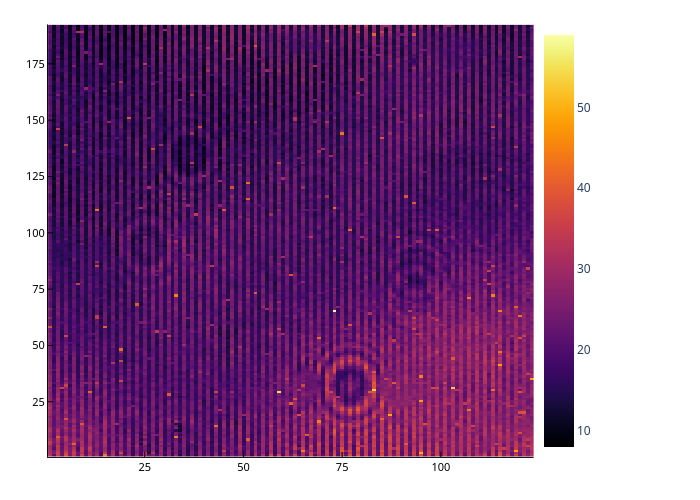

In [140]:
using StatsBase
function get_maximum(pixel::Vector{T}) where T
    pixel_stream = collect(skipmissing(pixel))
    h = fit(Histogram, pixel_stream, 0.0:1.0:255.0)
    idx = findfirst(==(maximum(h.weights)), h.weights)
    return h.edges[1][idx]
end
peaks = map(pixel -> get_maximum(pixel), tcspc_stream)
heatmap(peaks[:, 5:127])
# TODO: More useful would be in this case to plot uncertainty
#get_maximum(tcspc_stream[110, 20])

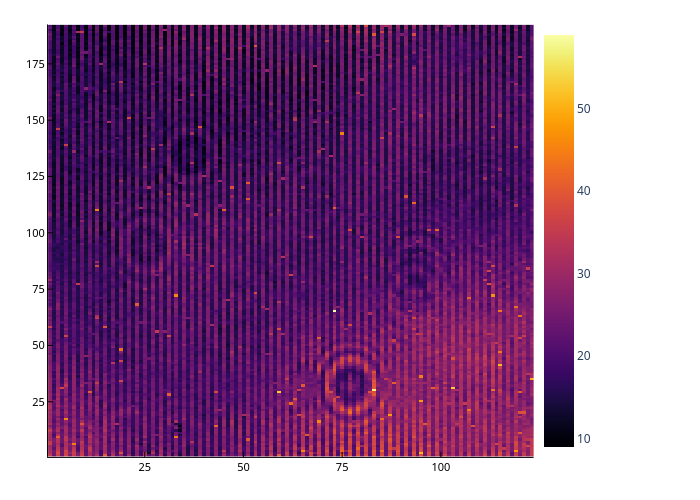

In [132]:
tcspc_var = map(pixel -> var(pixel[1],mean=pixel[2]), zip(tcspc_stream, peaks))
tcspc_std = map(pixel -> std(pixel[1],mean=pixel[2]), zip(tcspc_stream, peaks))
#typeof(peaks)
heatmap(map(peak -> minimum([peak, 150.0]), peaks[:, 5:127]))

### TDC Clock skew
The STOP clock is skewed lineraly across the sensor along the columns axis.

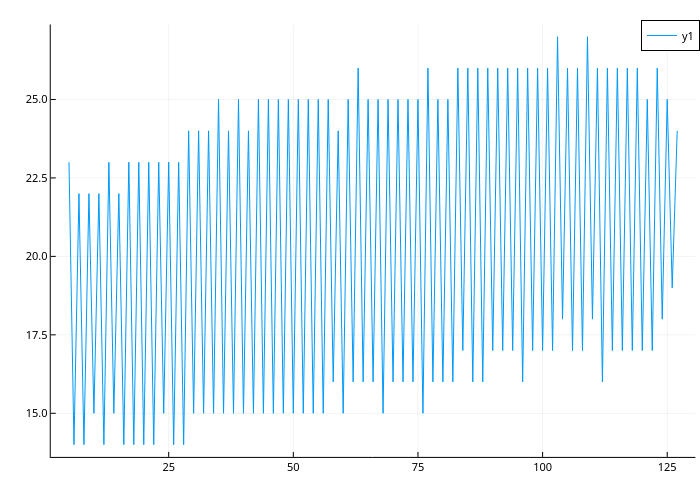

In [133]:
tcspc_col_stream = [vcat(tcspc_stream[:, col]...) for col in 1:size(tcspc_stream, 2)]
peaks_col = map(pixel -> get_maximum(pixel), tcspc_col_stream)
typeof(tcspc_col_stream)
plot(5:127, peaks_col[5:127])

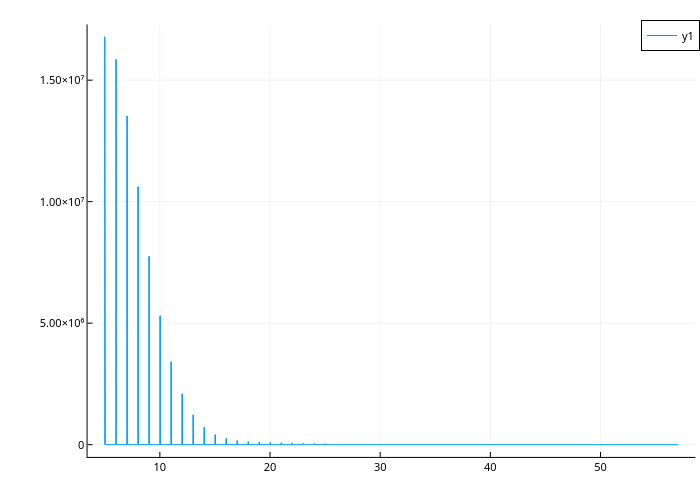

In [191]:
# ND=0.5
all_pixels = collect(Iterators.flatten(tcspc_stream[:,5:128]))
histogram(all_pixels, bins=1000)

WebIO._IJuliaInit()

┌ Warning: FRAME(3): Frames skipped expected_idx=3 to new_idx=200 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75
┌ Warning: FRAME(4): Frames skipped expected_idx=201 to new_idx=29 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75
┌ Warning: FRAME(8): Frames skipped expected_idx=33 to new_idx=56 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75
┌ Warning: FRAME(42): Frames skipped expected_idx=90 to new_idx=98 => Non continuous frames capture
└ @ QuantiCam ~/Documents/Scripts/Julia/opal-kelly/QuantiCam/src/utils.jl:75


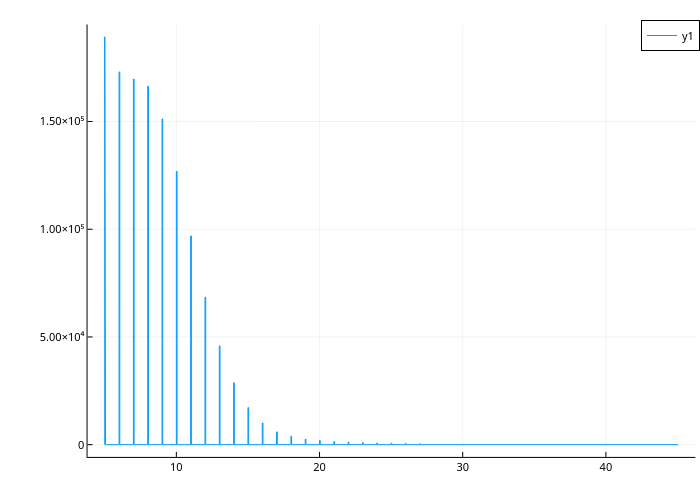

In [24]:
using QuantiCam
using Statistics
using Plots
plotlyjs()

frames = capture_frames(qc, 100);
filtered_frames = map(frame -> QuantiCam.filter_code(frame), frames)

function collect_frames(v::Vector{Matrix{T}}) where T
    n_rows = size(v[1], 1)
    n_cols = size(v[1], 2)
    n_matrices = length(v)
    
    result = Matrix{Vector{T}}(undef, n_rows, n_cols)
    
    for i in 1:n_rows, j in 1:n_cols
        result[i, j] = [v[k][i, j] for k in 1:n_matrices]
    end
    
    return result
end

#tcspc_stream = collect_frames([frames[:,:,i] for i in 1:size(frames,3)])
tcspc_stream_missing = collect_frames(filtered_frames)
tcspc_stream = map(pixel -> collect(skipmissing(pixel)), tcspc_stream_missing)
tcspc_mean = map(pixel -> mean(pixel), tcspc_stream)
tcspc_var = map(pixel -> var(pixel), tcspc_stream);

# ND=1.5
all_pixels = collect(Iterators.flatten(tcspc_stream[:,5:128]))
histogram(all_pixels, bins=1000)